In [1]:
import pandas as pd
import numpy as np

In [13]:
with open('dialog_acts.dat', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip("\n").split(" ", 1), data))

In [14]:
df = pd.DataFrame(np.array(data), columns = ['label', 'text'])

In [15]:
df.head()

,label,text
0,inform,im looking for a moderately priced restaurant ...
1,inform,any part of town
2,inform,bistro food
3,confirm,is there a moderately priced restaurant that s...
4,affirm,yes


In [ ]:
from sklearn.model_selection import train_test_split

# Pre-Processing

In [11]:
df.head()

,label,text
0,inform,im looking for a moderately priced restaurant ...
1,inform,any part of town
2,inform,bistro food
3,confirm,is there a moderately priced restaurant that s...
4,affirm,yes


In [12]:
df['text'].head()

0    im looking for a moderately priced restaurant ...
1                                     any part of town
2                                          bistro food
3    is there a moderately priced restaurant that s...
4                                                  yes
Name: text, dtype: object

In [13]:
# if text contains "noise" or "tv_noise", remove
# if that makes the column empty, remove the row

for index, row in df.iterrows():
    print(row['c1'], row['c2'])

KeyError: ignored

#bot

In [64]:
#Your code should offer a prompt to enter a new utterance and classify this utterance, and repeat the prompt until the user exits.

def classify_utterance_1(ut):
  classified_label = "inform"
  return classified_label

def classify_utterance_2(ut):
  if 'bye' in ut:
    classified_label = 'bye'
  elif 'no' in ut:
    classified_label = 'negate'
  elif 'start over' in ut:
    classified_label = 'restart'
  else:
    classified_label = 'null'

  return classified_label

def classify_utterance_3(ut):
  #classified_label = ml_lassifier_model.predict(ut)[0]
  classified_label_id = model.predict(tfidf.transform([ut]).toarray())[0]
  classified_label = label_dict.loc[classified_label_id][0]
  return classified_label

def bot():
  finished = False
  print(f'Hi! To exit enter "bye123"')
  while not finished:
    utterance = input('>').lower()
    label = classify_utterance_3(utterance)
    print(f'label:{label}\nutterance:{utterance}')  
    if 'bye123' in utterance:
      finished = True

In [6]:
bot()

Hi! To exit enter "bye123"
>you
you
>mine
mine
>hate you
hate you
>bye123
bye123


#ML model comparison

In [16]:
df

,label,text
0,inform,im looking for a moderately priced restaurant ...
1,inform,any part of town
2,inform,bistro food
3,confirm,is there a moderately priced restaurant that s...
4,affirm,yes
...,...,...
25496,request,what is the price range
25497,thankyou,thank you good bye
25498,inform,im looking for african food
25499,request,whats the address and phone number


In [17]:
df['label_id'] = df['label'].factorize()[0]

In [49]:
df

,label,text,label_id
0,inform,im looking for a moderately priced restaurant ...,0
1,inform,any part of town,0
2,inform,bistro food,0
3,confirm,is there a moderately priced restaurant that s...,1
4,affirm,yes,2
...,...,...,...
25496,request,what is the price range,3
25497,thankyou,thank you good bye,4
25498,inform,im looking for african food,0
25499,request,whats the address and phone number,3


In [65]:
label_dict = df[['label','label_id']].drop_duplicates().set_index('label_id')
label_dict

,label
label_id,
0,inform
1,confirm
2,affirm
3,request
4,thankyou
5,null
6,bye
7,reqalts
8,negate


In [20]:
from sklearn.model_selection import train_test_split
text_train, text_test, label_train, label_test = train_test_split(df['text'], df['label_id'], test_size=0.15, random_state=10)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf = TfidfVectorizer(sublinear_tf=True, #scale the words frequency in logarithmic scale
                        min_df=5, #remove the words which has occurred in less than ‘min_df’ number of files
                        ngram_range=(1, 2), #dont know what role n-grams play in vectorisation
                        stop_words='english', #it removes stop words which are predefined in ‘english’.
                        lowercase=True #everything to lowercase
                        )

features = tfidf.fit_transform(text_train).toarray()
labels = label_train

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [24]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=400),
]

In [26]:
from sklearn.model_selection import cross_val_score

In [77]:

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy')
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


In [78]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LogisticRegression,0.879954,0.002417
MultinomialNB,0.857070,0.001920
RandomForestClassifier,0.682860,0.025147


In [40]:
#seems like LogisticRegression is the best or we can tweek the hyperparameters more. 

In [30]:
features_test = tfidf.transform(text_test).toarray()

In [31]:
model = LogisticRegression(random_state=0, max_iter=400)
model.fit(features, labels)
label_pred = model.predict(features_test)

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [35]:
print(metrics.classification_report(label_test, label_pred, 
                                    target_names= df['label'].unique()))

              precision    recall  f1-score   support

      inform       0.79      0.96      0.87      1535
     confirm       0.56      0.26      0.36        19
      affirm       1.00      0.95      0.98       188
     request       0.95      0.98      0.96       970
    thankyou       0.98      1.00      0.99       452
        null       0.93      0.78      0.85       254
         bye       1.00      0.87      0.93        31
     reqalts       0.48      0.08      0.14       271
      negate       0.00      0.00      0.00        69
       hello       0.92      0.65      0.76        17
      repeat       0.86      0.67      0.75         9
         ack       0.00      0.00      0.00         5
     restart       1.00      1.00      1.00         3
        deny       0.00      0.00      0.00         2
     reqmore       0.00      0.00      0.00         1

    accuracy                           0.87      3826
   macro avg       0.63      0.55      0.57      3826
weighted avg       0.84   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt 

Text(0.5, 24.0, 'Predicted')

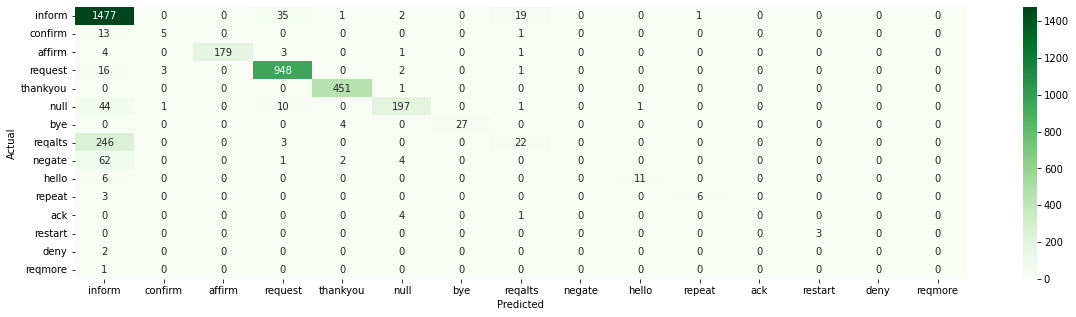

In [76]:
conf_mat = confusion_matrix(label_test, label_pred)
plt.figure(figsize = (20,5))
sns.heatmap(conf_mat, annot=True, cmap='Greens', fmt='d',
            xticklabels=label_dict.label.values, 
            yticklabels=label_dict.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#exploration

In [59]:
df.describe()

,label,text
count,25501,25501
unique,15,5359
top,inform,thank you good bye
freq,10160,2565


In [72]:
df.groupby('label').describe().sort_values(('text','count'))

text                                      
          count unique                      top  freq
label                                                
reqmore       5      1                     more     5
restart      14      7               start over     7
deny         27     13                    wrong    14
ack          28     20                  okay um     7
repeat       33     13                   repeat     6
hello        93     60                    hello    24
confirm     172    115  is it moderately priced    11
bye         266     41                 good bye   137
negate      435    133                       no   264
affirm     1156    166                      yes   803
null       1612    249                    noise   408
reqalts    1747    437   is there anything else   302
thankyou   3259     81       thank you good bye  2565
request    6494    961             phone number   914
inform    10160   3062              i dont care   613

In [57]:
bot()

Hi! To exit enter "bye123"
>you suck
label:inform
utterance:you suck
>i love you
label:inform
utterance:i love you
>what is to eat?
label:inform
utterance:what is to eat?
>what do you lie?
label:inform
utterance:what do you lie?
>can I play?
label:inform
utterance:can i play?
>hello
label:hello
utterance:hello
>no
label:inform
utterance:no
>bye123
label:inform
utterance:bye123
